In [ ]:
# Notebook to calculate backprop for the grand loss in MTT, i.e. 'gradient of gradients'

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
# First we test using only linear layers

# Linear layers y = xWT + b

# Layer 1
in_dim = (5, 4)
out_dim = 7
x1 = torch.rand(*in_dim, requires_grad=True)
WT1 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b1 = torch.randn(out_dim, requires_grad=True)
y1 = x1 @ WT1 + b1
y1.retain_grad()
# print(y1.shape)

# Layer 2
in_dim = y1.shape
out_dim = 4
WT2 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b2 = torch.randn(out_dim, requires_grad=True)
y2 = y1 @ WT2 + b2
y2.retain_grad()
# print(y2.shape)

# Layer 3
in_dim = y2.shape
out_dim = 3
WT3 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b3 = torch.randn(out_dim, requires_grad=True)
out = y2 @ WT3 + b3
out.retain_grad() # Output of network

# Sanity check
# print(out == (((x1 @ WT1 + b1) @ WT2 + b2)) @ WT3 + b3)

# Loss
target = torch.randn(out.shape)
loss_fn = nn.MSELoss()
output = loss_fn(out, target)
output.retain_grad()
output.backward()

dout_val = 2 * (out - target) / np.prod(out.shape) # derivative of MSELoss
dx1_val = 0

# print(dout_val)
# print(out.grad)




In [ ]:
# Only tensors that are not computed from other tensors are leaves.
# This tells us that all weight and bias tensors are leaves initally.
# for var in [x1, y2, out, WT1, WT2, WT3, b1, b2, b3]:
#     print(var.is_leaf)

# print(WT1)
# print(WT1.grad)

# optimizer = torch.optim.SGD([WT1, WT2, WT3, b1, b2, b3], lr=0.1)
# # Perform one step of SGD
# optimizer.step()

# # WT1 has now been updated, but is still a leaf (no dependencies!)
# print(WT1)

# p_stacked = torch.cat[]

In [ ]:
# # Calculating the grand loss as described in MTT

# # First flatten and concatenate all the parameters
# # parameters = [
# #     WT1.detach().clone(),
# #     WT2.detach().clone(),
# #     WT3.detach().clone(),
# #     b1.detach().clone(),
# #     b2.detach().clone(),
# #     b3.detach().clone(),
# # ]
# parameters = [
#     WT1,
#     WT2,
#     WT3,
#     b1,
#     b2,
#     b3,
# ]

# # All the parameters should be leaves because they don't have dependencies
# # for var in parameters:
# #     print(var.is_leaf)
# p_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)
# # p_stacked.retain_grad()
# # Sanity check
# num_param = sum(np.prod(p.shape) for p in parameters)
# print(p_stacked.shape[0] == num_param)

# # # Imaginary start and end expert parameters
# # exp_start_stacked = torch.randn(p_stacked.shape)
# # exp_end_stacked = torch.randn(p_stacked.shape)

# # param_loss_mse = nn.MSELoss(reduction='sum')
# # param_dist_mse = nn.MSELoss(reduction='sum')

# # param_loss = param_loss_mse(p_stacked, exp_end_stacked)
# # param_loss /= num_param
# # param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# # param_dist /= num_param

# # grand_loss = param_loss / param_dist

# # print(grand_loss)
# # print(WT1.grad)
# # print(p_stacked.grad)
# # grand_loss.backward()
# # print(p_stacked.grad)
# # print(WT1.grad)

# # Let us compare this to a manual calculation of the gradients, by using the forward pass

# # Do for the variable WT1



In [ ]:
# First we test using only linear layers

# Linear layers y = xWT + b

# Layer 1
in_dim = (9, 4)
out_dim = 7
x1 = torch.rand(*in_dim, requires_grad=True)
WT1 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b1 = torch.randn(out_dim, requires_grad=True)
y1 = x1 @ WT1 + b1
y1.retain_grad()

# Layer 2
in_dim = y1.shape
out_dim = 4
WT2 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b2 = torch.randn(out_dim, requires_grad=True)
y2 = y1 @ WT2 + b2
y2.retain_grad()

# Layer 3
in_dim = y2.shape
out_dim = 3
WT3 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b3 = torch.randn(out_dim, requires_grad=True)
out = y2 @ WT3 + b3
out.retain_grad() # Output of network

# Sanity check
# print(out == (((x1 @ WT1 + b1) @ WT2 + b2)) @ WT3 + b3)

# output.retain_grad()
# output.backward()

# dout_val = 2 * (out - target) / np.prod(out.shape) # derivative of MSELoss
# dx1_val = 0

# # Sanity check
# print(torch.allclose(dout_val, out.grad))

# First flatten and concatenate all the parameters. These can be considered references,
# not copies, so they retain their computational graphs if used.
student_parameters = {
    "WT1": WT1,
    "WT2" : WT2,
    "WT3" : WT3,
    "b1" : b1,
    "b2" : b2,
    "b3" : b3,
    "x1": x1,
    # "y1" : y1,
    # "y2" : y2
}
# All the parameters should be leaves because they don't have dependencies
# for var in student_parameters.values():
#     print(var.is_leaf)
p_stacked = torch.cat([p.reshape(-1) for p in student_parameters.values()]).requires_grad_(True)

# # Sanity check
num_param = sum(np.prod(p.shape) for p in student_parameters.values())
# print(p_stacked.shape[0] == num_param)

# # Calculate the traditional loss, however instead of using backward method, we use autograd manually
# # In this way, the grad attributes of each parameter is not populated, and we can use them
# # to instead compute the grand loss.
target = torch.empty(out.shape[0], dtype=torch.long).random_(
    out.shape[1]
)  # Imaginary target values. Must be type torch.long for CE function
loss_fn = nn.CrossEntropyLoss()
output = loss_fn(out, target)
grad = torch.autograd.grad(outputs=output, inputs=student_parameters.values(), create_graph=True)
grad_stacked = torch.cat([p.reshape(-1) for p in grad]).requires_grad_(True)
grad_descent = p_stacked - 0.1 * grad_stacked

# Sanity check (comment out when computing grand loss!)
# output.backward()
# print(parameters[0].grad)
# print(WT1.grad)
# WT1.grad[0] += 1
# print(parameters[0].grad)
# print(WT1.grad)

# Imaginary start and end expert parameters
exp_start_stacked = torch.randn(p_stacked.shape)
exp_end_stacked = torch.randn(p_stacked.shape)

param_loss_mse = nn.MSELoss(reduction='sum')
param_dist_mse = nn.MSELoss(reduction='sum')

param_loss = param_loss_mse(grad_descent, exp_end_stacked)
param_loss /= num_param
param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
param_dist /= num_param

grand_loss = param_loss / param_dist
# grand_loss = param_loss
print(grand_loss)
grand_loss.backward()
_ = 0

# Not sure how the loss back propagates, hence will rewrite using PyTorch layers


In [ ]:
print(x1.grad)

print()

In [ ]:
from torchviz import make_dot

graph = make_dot(grand_loss, params=student_parameters)

graph

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# import os

# # Batch
# N = 7

# # Linear layer shapes
# l1 = (4, 6)
# l2 = (6, 5)
# l3 = (5, 9)

# layers = nn.Sequential(
#     nn.Linear(*l1), nn.Linear(*l2), nn.Linear(*l3)
# )

# parameters = [
#     layers[0].weight,
#     layers[1].weight,
#     layers[2].weight
# ]

# # All the parameters should be leaves because they don't have dependencies
# # for var in parameters:
# #     print(var.is_leaf)
# p_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)

# # Calculate the traditional loss, however instead of using backward method, we use autograd manually
# # In this way, the grad attributes of each parameter is not populated, and we can use them
# # to instead compute the grand loss.
# x = torch.randn(N, l1[0])
# out = layers(x)
# target = torch.empty(N, dtype=torch.long).random_(
#     l3[1]
# )  # Imaginary target values. Must be type torch.long for CE function
# loss_fn = nn.CrossEntropyLoss()
# output = loss_fn(out, target)
# grad = torch.autograd.grad(outputs=output, inputs=parameters, create_graph=True)
# grad_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)
# grad_descent = p_stacked - 0.1 * grad_stacked

# # Imaginary start and end expert parameters
# exp_start_stacked = torch.randn(p_stacked.shape)
# exp_end_stacked = torch.randn(p_stacked.shape)

# param_loss_mse = nn.MSELoss(reduction='sum')
# param_dist_mse = nn.MSELoss(reduction='sum')

# param_loss = param_loss_mse(grad_descent, exp_end_stacked)
# param_loss /= num_param
# # param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# # param_dist /= num_param

# # # TensorBoard
# # log_path = os.path.join("testing")
# # tb_logger = SummaryWriter(log_path)

# # tb_logger.add_graph(
# #     layers,
# #     torch.randn(7, 4)
# # )


In [42]:
# Lets instead try to do everything with just a single layer, to understand what is going on

# Layer 1
in_dim = (9, 4)
out_dim = 7
x = torch.rand(*in_dim, requires_grad=True)
WT = torch.rand(in_dim[-1], out_dim, requires_grad=True)
b = torch.randn(out_dim, requires_grad=True)
out = x @ WT + b
out.retain_grad()

parameters = {
    # "x" : x,
    "WT" : WT,
    "b" : b
}

p_stacked = torch.cat([p.reshape(-1) for p in parameters.values()]).requires_grad_(True)

# # Sanity check
num_param = sum(np.prod(p.shape) for p in parameters.values())
# print(p_stacked.shape[0] == num_param)

target = torch.empty(out.shape[0], dtype=torch.long).random_(
    out.shape[1]
)  # Imaginary target values. Must be type torch.long for CE function
loss_fn = nn.CrossEntropyLoss()
output = loss_fn(out, target)
# output.retain_grad()
# output.backward()

# print(output.grad)
grad = torch.autograd.grad(outputs=output, inputs=parameters.values(), create_graph=True)
print(out.grad)
# grad_stacked = torch.cat([p.reshape(-1) for p in grad]).requires_grad_(True)
# grad_descent = p_stacked - 0.1 * grad_stacked

# # Imaginary start and end expert parameters
# exp_start_stacked = torch.randn(p_stacked.shape)
# exp_end_stacked = torch.randn(p_stacked.shape)

# param_loss_mse = nn.MSELoss(reduction='sum')
# param_dist_mse = nn.MSELoss(reduction='sum')

# param_loss = param_loss_mse(grad_descent, exp_end_stacked)
# param_loss /= num_param
# param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# param_dist /= num_param

# grand_loss = param_loss / param_dist
# # grand_loss = param_loss
# print(grand_loss)
# grand_loss.backward()

# print(output.grad)



tensor([[ 0.0031,  0.0268,  0.0128, -0.0907,  0.0246,  0.0030,  0.0204],
        [-0.1088,  0.0275,  0.0119,  0.0301,  0.0182,  0.0035,  0.0177],
        [ 0.0026,  0.0283,  0.0129, -0.0875,  0.0207,  0.0035,  0.0195],
        [ 0.0027,  0.0329,  0.0119, -0.0916,  0.0204,  0.0034,  0.0202],
        [-0.1078,  0.0306,  0.0123,  0.0181,  0.0238,  0.0033,  0.0197],
        [ 0.0036,  0.0213,  0.0132,  0.0202,  0.0300, -0.1086,  0.0204],
        [ 0.0031,  0.0280, -0.0984,  0.0210,  0.0237,  0.0033,  0.0191],
        [-0.1088,  0.0335,  0.0118,  0.0197,  0.0187,  0.0033,  0.0218],
        [ 0.0021,  0.0268,  0.0153,  0.0261,  0.0177, -0.1068,  0.0188]],
       grad_fn=<CloneBackward0>)


In [43]:
print(x.grad)
# print(out.grad)
# print(WT.grad)
print((out.grad @ WT.T))

None
tensor([[ 0.0441, -0.0048,  0.0399,  0.0279],
        [ 0.0124,  0.0246, -0.0622,  0.0093],
        [ 0.0442, -0.0034,  0.0367,  0.0270],
        [ 0.0477, -0.0016,  0.0384,  0.0286],
        [ 0.0174,  0.0237, -0.0551,  0.0129],
        [-0.0226,  0.0196,  0.0564,  0.0198],
        [ 0.0013,  0.0402,  0.0302,  0.0034],
        [ 0.0192,  0.0264, -0.0579,  0.0133],
        [-0.0203,  0.0234,  0.0471,  0.0183]], grad_fn=<MmBackward0>)


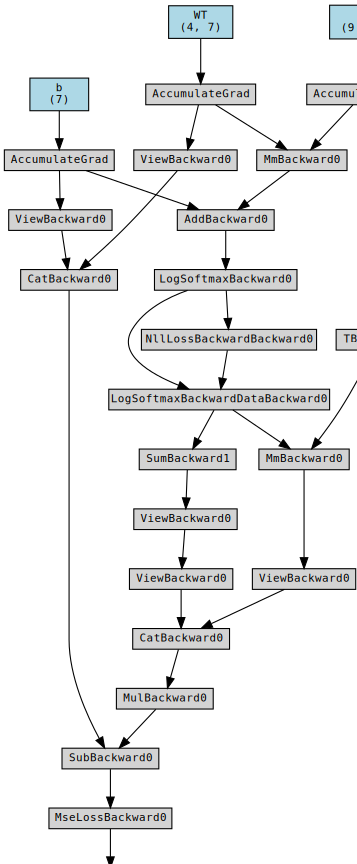

In [21]:
from torchviz import make_dot

graph = make_dot(grand_loss, params=parameters)

graph

In [204]:
# Calculate dw using PyTorch autograd, and then manually by calculating the forward pass, and using the incoming gradients of PyTorch

gradients = []


# Define hook function to capture incoming gradients
def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_input)


# Batch
N = 7

# Linear layer shapes
l1 = (4, 6)
l2 = (6, 5)
l3 = (5, 9)
l4 = (9, 12)

layers = nn.Sequential(
    nn.Linear(*l1), nn.Linear(*l2), nn.Linear(*l3), nn.Linear(*l4)
)

# Remember that these gradients are saved during backprop
for layer in layers:
    layer.register_full_backward_hook(save_gradients)

x = torch.randn(N, l1[0]) # Does not have a grad until we do grand loss
out = layers(x)
out.retain_grad()
target = torch.empty(N, dtype=torch.long).random_(
    layers[-1].weight.shape[1]
)  # Imaginary target values. Must be type torch.long for CE function
loss_fn = nn.CrossEntropyLoss()
output = loss_fn(out, target)
output.backward()

# We only copy dw and not db because it is a function of x (input of DNN)
# We detach them so that they are not part of a computational graph
# On FPGA, these will simply be stored in memory
grad_truth = {
    "l1_dw": layers[0].weight.grad.detach().clone(),
    "l2_dw": layers[1].weight.grad.detach().clone(),
    "l3_dw": layers[2].weight.grad.detach().clone(),
    "l4_dw": layers[3].weight.grad.detach().clone(),
    "l4_dout": out.grad.detach().clone(),  # Special case
    "l3_dout": gradients[0][0].detach().clone(),
    "l2_dout": gradients[1][0].detach().clone(),
    "l1_dout": gradients[2][0].detach().clone(),
}

# END OF PYTORCH TRUTH

x.requires_grad_(True)
# # Should all be leaves because they have no dependencies
# for key, val in grad_truth.items():
#     print(f"{key} is leaf: {val.is_leaf}")

# Now we manually calculate the dw so w can perform backprop to find x
# Remember, for Linear layer, dw = dout.T @ input
grad_val = {
    "l1_dw": grad_truth["l1_dout"].T @ x,
    "l2_dw": grad_truth["l2_dout"].T @ layers[0:1](x),
    "l3_dw": grad_truth["l3_dout"].T @ layers[0:2](x),
    "l4_dw": grad_truth["l4_dout"].T @ layers[0:3](x),
}

# Ensure that all of these gradients require gradient calculations
# for grad in grad_val.values():
#     print(grad.requires_grad)

# Ensure calculated gradients match PyTorch
assert torch.allclose(grad_val["l1_dw"], grad_truth["l1_dw"])
assert torch.allclose(grad_val["l2_dw"], grad_truth["l2_dw"])
assert torch.allclose(grad_val["l3_dw"], grad_truth["l3_dw"])
assert torch.allclose(grad_val["l4_dw"], grad_truth["l4_dw"])

# No dw are leaves, because they are all functions of x
# for key, val in grad_val.items():
#     print(f"{key} is leaf: {val.is_leaf}")

# # Now let us perform SGD using built in PyTorch functionality
# This is done to ensure that we don't accidentally mess things up when backprop
# the grand loss

# # Tuples for each layer, ignoring bias again since not function of x
parameters_val = [l.weight.detach().clone() for l in layers]
optimizer = torch.optim.SGD(
    [l.weight for l in layers] + [l.bias for l in layers], lr=0.1
)
optimizer.step()


# Now do SGD manually to ensure correct behaviour and compare to PyTorch SGD
for idx, layer in enumerate(parameters_val):
    layer.requires_grad_(True)  # Retain gradients
    layer = (
        layer - 0.1 * grad_val[f"l{idx + 1}_dw"]
    )  # Updated parameter with knowledge of x
    assert torch.allclose(layer, layers[idx].weight)

# Now we flatten all the parameters, to calculate grand loss
p_stacked = torch.cat([p.reshape(-1) for p in parameters_val]).requires_grad_(
    True
)  # CatBackward0

# Imaginary target values. Must be type torch.long for CE function
# In MTT, these correspond to the updated expert parameters
# target = torch.empty(p_stacked.shape[0], dtype=torch.long).random_(out.shape[1])
target = torch.randn(p_stacked.shape[0])
loss_fn = nn.MSELoss(reduction="sum")  # Unnormalized, just like MTT
loss = loss_fn(p_stacked, target)  # MseLossBackward0
loss.backward()

tensor([[ 0.0174,  0.0225, -0.0031, -0.0238],
        [ 0.0278, -0.0085,  0.0084, -0.0015],
        [ 0.0357, -0.0055,  0.0010,  0.0051],
        [-0.0076,  0.0057,  0.0003, -0.0067],
        [-0.0103, -0.0240,  0.0170,  0.0130],
        [-0.0355, -0.0077,  0.0011,  0.0103]], grad_fn=<MmBackward0>)


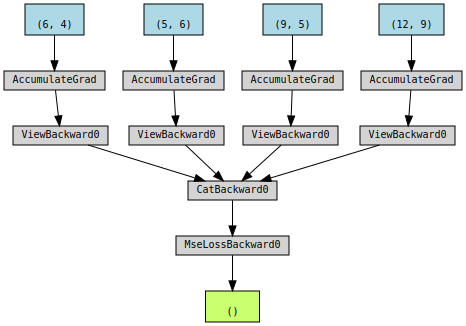

In [205]:
from torchviz import make_dot

graph = make_dot(loss)

graph

In [131]:
# print(layers[0].weight)
# print(parameters_val[0])